# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# import everything together, to avoid missing imports after a break
import pickle
import numpy
import pandas
import os
import cv2
import csv
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from collections import Counter
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
#LeNet parameters
EPOCHS = 40
BATCH_SIZE = 100
LEARN_RATE = 0.001

# folder name of additional test images (Step 3)
my_images_dir = "test/"

In [3]:
# Load pickled data

training_file = 'images/train.p'
validation_file='images/valid.p'
testing_file =  'images/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# : Number of training examples
n_train = numpy.size(X_train,0)

# : Number of validation examples
n_validation = numpy.size(X_valid,0)

# : Number of testing examples.
n_test = numpy.size(X_test,0)

# : What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# : How many unique classes/labels there are in the dataset.
unique_elements, counts_elements = numpy.unique(y_train, return_counts=True)
n_classes = len(unique_elements)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

In [5]:
# import signnames into a dictionary

# open the csv file
input_file = csv.DictReader(open("signnames.csv"))
mydict = []
# add each line to a dictionary
for line in input_file:
    mydict.append(line)

{'ClassId': '4', 'SignName': 'Speed limit (70km/h)'}


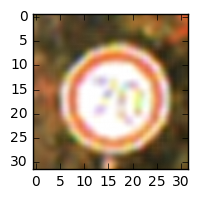

{'ClassId': '12', 'SignName': 'Priority road'}


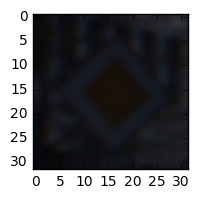

{'ClassId': '2', 'SignName': 'Speed limit (50km/h)'}


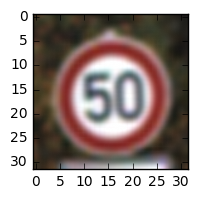

{'ClassId': '35', 'SignName': 'Ahead only'}


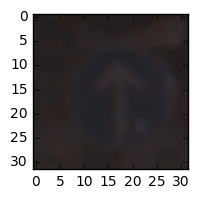

{'ClassId': '35', 'SignName': 'Ahead only'}


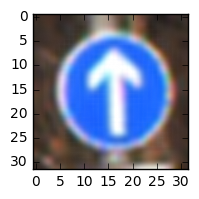

In [6]:
### Data exploration visualization code goes here.

# show 5 random images
for a in range(5):
    # get random image
    a=(random.randint(0,n_train))
    data=X_train[a]
    
    # print name of traffic sign from dictionary
    print(mydict[y_train[a]])
    
    # show small image with a good interpolation
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation="bessel")
    plt.show()

In [7]:
# Count images per sign to plot the occurances
train_signs_by_id = sorted(Counter(y_train).items())
valid_signs_by_id = sorted(Counter(y_valid).items())
test_signs_by_id = sorted(Counter(y_test).items())

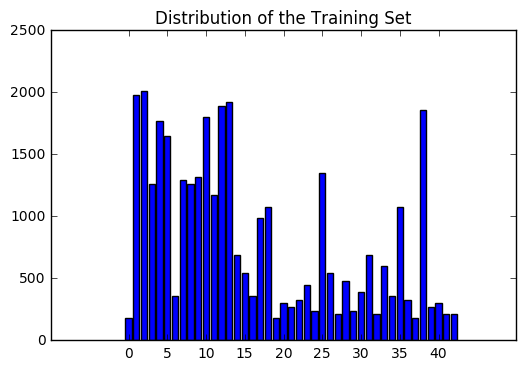

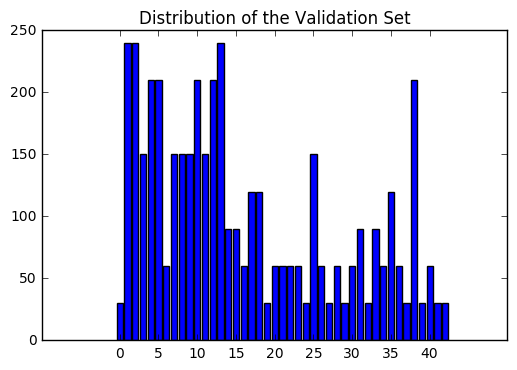

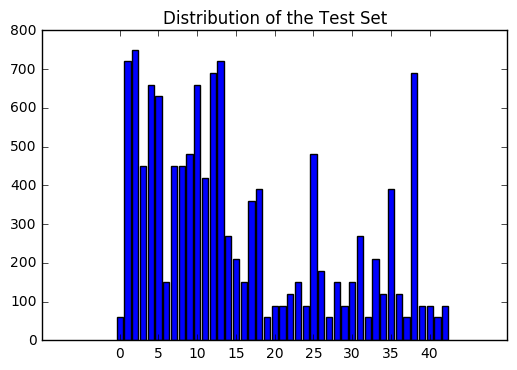

In [8]:
# plot a list of key-value-pairs with a specific title
def plot_counts(list, title):
    sign, counts = zip(*list)
    plt.bar(sign, counts, align='center')
    plt.xticks(range(0, n_classes, 5))
    plt.title(title)
    plt.show()
    
#plot all data sets
plot_counts(train_signs_by_id,'Distribution of the Training Set')
plot_counts(valid_signs_by_id,'Distribution of the Validation Set')
plot_counts(test_signs_by_id,'Distribution of the Test Set')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize german traffic signs.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [9]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

In [10]:
def normalize(img):
    return (img-128.)/128.

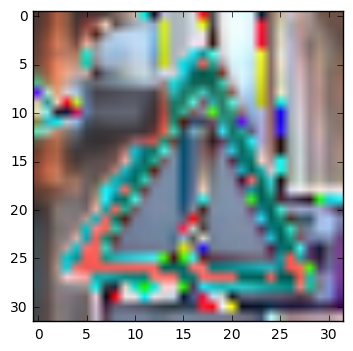

In [11]:
# shuffle the images
X_train, y_train = shuffle(X_train, y_train)
# TODO: shuffle test and validation, too ?

# apply normalization to all images
X_train = numpy.array([normalize(img) for img in X_train])
X_valid = numpy.array([normalize(img) for img in X_valid])
X_test = numpy.array([normalize(img) for img in X_test])

# display some image, just to see applied normalization
testimage=X_train[5000].squeeze()
plt.imshow(testimage)
plt.show()

### Model Architecture

In [12]:
### Define the architecture here.

# global variable for Step4 - Visualization
tensor_for_visual=tf.Variable(0)

# LeNet architecture from Udacity
def mynet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6
    conv1_W= tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean = mu, stddev = sigma))
    conv1_b= tf.Variable(tf.zeros(6)) 
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b
    
    # Activation with prevention from overfitting: 
    conv1 = tf.nn.dropout(tf.nn.relu(conv1), keep_prob)
    
    # Pooling. Input = 28x28x6. Output= 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16
    conv2_W= tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    conv2_b= tf.Variable(tf.zeros(16)) 
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # Activation with prevention from overfitting: 
    conv2 = tf.nn.dropout(tf.nn.relu(conv2), keep_prob)
    
    # Pooling. Input = 10x10x16. Output= 5x5x16
    conv2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME'), keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400
    fc0 = flatten(conv2)
    
    # Layer 3: Fully connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0,fc1_W) + fc1_b
    
    # Activation with prevention from overfitting: 
    fc1 = tf.nn.dropout(tf.nn.relu(fc1), keep_prob)
    
    # Layer 4: Fully connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_W) + fc2_b
    
    # Activation with prevention from overfitting: 
    fc2 = tf.nn.dropout(tf.nn.relu(fc2), keep_prob)    
    
    # Layer 5: Fully connected. Input = 120. Output = number of classes
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    
    ### set global variable with the feature map, you want to visualize in optional step 4
    # SELECT HERE:
    tensor_for_visual = conv2
    
    return tf.matmul(fc2,fc3_W) + fc3_b

### Train, Validate and Test the Model

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

In [14]:
# placeholder Tensors
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [15]:
# initialze LeNet
one_hot_y = tf.one_hot(y, 43)
logits = mynet(x)

# calculate cross-entropy and loss function
#use softmax_cross_entropy_with_logits_v2 as v1 is depreceated
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)

In [16]:
# calculate the prediction accuracy
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
# Learn

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

In [17]:
# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet')

    # Print out accuracy after restore
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Training set accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.944
Training set accuracy = 0.999
Validation set accuracy = 0.950


---

## Step 3: Test a Model on New Images

I downloaded 5 german traffic signs from google.
I used the same normalization technique as above, to have the images in the exact same style.

### Load and Output the Images

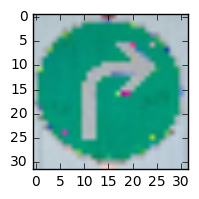

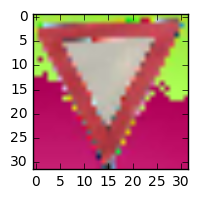

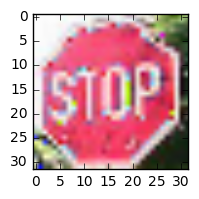

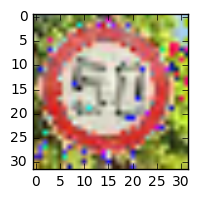

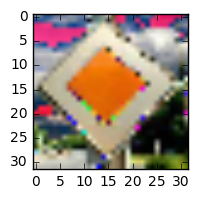

In [18]:
# Load all images from folder
my_images = os.listdir(my_images_dir)
images_orig = numpy.array([cv2.resize(plt.imread(my_images_dir + image), (32, 32)) for image in my_images])

# apply normalization techniques as above
images_norm = numpy.array([normalize(image) for image in images_orig])

# plot all images 
for image in images_norm:
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.show()

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet
Image name 	: Prediction
33.jpg 		: {'ClassId': '33', 'SignName': 'Turn right ahead'}


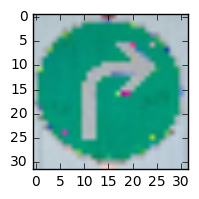

13.jpg 		: {'ClassId': '13', 'SignName': 'Yield'}


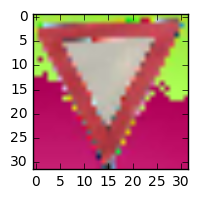

14.jpg 		: {'ClassId': '14', 'SignName': 'Stop'}


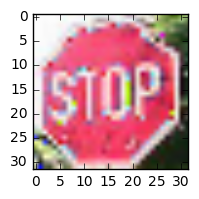

2.jpg 		: {'ClassId': '1', 'SignName': 'Speed limit (30km/h)'}


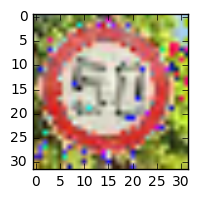

12.jpg 		: {'ClassId': '12', 'SignName': 'Priority road'}


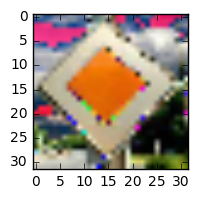

In [19]:
### Run the predictions here and use the model to output the prediction for each image.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: images_norm, keep_prob: 1.0})
    
# print the image filename followed by the predicted signname and id
print('Image name \t: Prediction')
i = 0
for result in predictions:
    print(my_images[i], '\t\t:', mydict[result])
    plt.figure(figsize=(2,2))
    plt.imshow(images_norm[i])
    plt.show()
    i = i + 1

### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 

# get expected traffic-sign-id from the integer in the filename
image_ids = numpy.array([int(image.split('.')[0]) for image in my_images])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_accuracy = evaluate(images_norm,image_ids)
    
print("My Accuracy = ", my_accuracy)

INFO:tensorflow:Restoring parameters from ./lenet
My Accuracy =  0.800000011921


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # calculate the softmaxes for the 5 images
    softmaxes = sess.run(tf.nn.softmax(logits), feed_dict={x: images_norm, keep_prob: 1.0})
    
    # get the top 5 probabilites for each image
    values, indices = sess.run(tf.nn.top_k(softmaxes, k=5))
    
numpy.set_printoptions(precision=5)
print('\n' + str(values), indices)

INFO:tensorflow:Restoring parameters from ./lenet

[[  1.00000e+00   1.68169e-09   1.22268e-10   2.91147e-11   8.90455e-13]
 [  1.00000e+00   1.71279e-13   1.07917e-14   8.68129e-16   1.25393e-16]
 [  1.00000e+00   2.29920e-08   8.65639e-09   5.63177e-09   2.15121e-09]
 [  6.24491e-01   3.75509e-01   1.19153e-08   2.74972e-09   7.38151e-12]
 [  1.00000e+00   3.64676e-23   1.16423e-26   1.98901e-27   5.57245e-28]] [[33 39 11 40 35]
 [13 14 29 12  5]
 [14 13  5  1 15]
 [ 1  2  0  4 13]
 [12 26 32 11 25]]


### Project Writeup

See markdown file.

# TODO:

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #TODO: Still bugs in method call
    outputFeatureMap(sess, images_norm[0], tensor_for_visual)